---
title: "`Autogluon`과 시계열 자료"
author: "강신성"
date: "2023-12-10"
categories: [autogluon]
---




> `autogluon`을 이용하여 시계열자료를 분석해보자...?

## 1. 라이브러리 imports

In [1]:
#!pip install autogluon.common

In [2]:
#!pip install autogluon.multimodal 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor  ## TimeSeries 분석에 필요

import os
import warnings
warnings.filterwarnings('ignore')

## 2. 데이터

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,2:4].set_axis(['date','temp'],axis=1).assign(date= lambda df: df.date.apply(pd.to_datetime))
df_train = df[:580].assign(item_id = '평균기온')
df_test = df[580:].assign(item_id = '평균기온')

> 전주시 평균 기온 데이터를 받아왔고, 열 이름을 바꿔줬으며, `date`열의 자료 형식을 `pandas.datetime`으로 바꿔줬다.

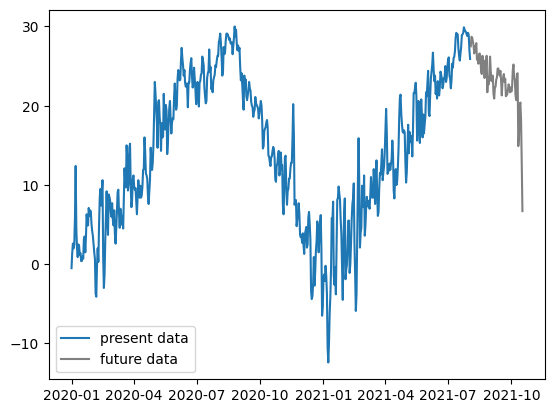

In [5]:
plt.plot(df_train.date, df_train.temp, label = 'present data')
plt.plot(df_test.date, df_test.temp, color = 'gray', label = 'future data')
plt.legend()
plt.show()

> 전주시 날짜별 평균 기온을 나타낸 시계열 자료이다.

## 3. `TimeSeriesPredictor`에 대한 이해

오토글루온에서의 `tabular`분석과, `timeseries`분석에는 어떠한 차이가 있는가?

* `tabular` : `predictr.fit(df_train) / predictr.predict(df_test)`
* `timeseries` : `predictr.fit(ts_train) / predictr.predict(ts_train)`

> 시계열자료에서 `df_test`는 주어지지 않고, 기존 자료들에 근거해서만 미래 예측이 이뤄진다...

`-` 오토글루온에서 분석가능한 시계열자료의 형태

#### A. 하나의 시계열

In [6]:
df1 = pd.DataFrame({'시간':['2023-12-07','2023-12-08'], '종목':['삼성전자']*2, '주가':[72600, 72800]})
df1

,시간,종목,주가
0,2023-12-07,삼성전자,72600
1,2023-12-08,삼성전자,72800


> 말그대로 단일 시계열자료이다. 주식으로 치자면 한 개의 종목에 관한 시계열 자료만 예측하는 것이다.

In [7]:
ts1 = TimeSeriesDataFrame(
    data = df1,
    static_features = None,  ## 아직은 퓨어하다.
    id_column = '종목',  ## 시계열 집단에 대한 정보
    timestamp_column = '시간'  ## 시간 정보
)

ts1

주가
item_id timestamp        
삼성전자    2023-12-07  72600
        2023-12-08  72800

> 이런 식으로 데이터프레임을 `timeseries`의 형태로 변환시켜주어야 한다.

#### B. 여러 개의 시계열

In [8]:
df2 = pd.DataFrame({'시간':['2023-12-07','2023-12-08']*2, '종목':['삼성전자']*2+['카카오']*2, '주가':[72600, 72800, 51700, 51600]})
df2

,시간,종목,주가
0,2023-12-07,삼성전자,72600
1,2023-12-08,삼성전자,72800
2,2023-12-07,카카오,51700
3,2023-12-08,카카오,51600


> 종목이 두 개인 상황이다.

In [9]:
df2 = pd.DataFrame({'시간':['2023-12-07','2023-12-08']*2, '종목':['삼성전자']*2+['카카오']*2, '주가':[72600, 72800, 51700, 51600]})

ts2 = TimeSeriesDataFrame(
    data = df2,
    static_features = None,
    id_column = '종목',
    timestamp_column = '시간'
)

ts2

주가
item_id timestamp        
삼성전자    2023-12-07  72600
        2023-12-08  72800
카카오     2023-12-07  51700
        2023-12-08  51600

#### C. 여러 개의 시계열 + `static_features`

In [10]:
df2 = pd.DataFrame({'시간':['2023-12-07','2023-12-08']*2, '종목':['삼성전자']*2+['카카오']*2, '주가':[72600, 72800, 51700, 51600]})
df3 = pd.DataFrame({'종목':['삼성전자','카카오'],'특징1(기업성격)':['제조','IT'],'특징2(사원수)':[500,25]})  ## static_features data
display(df2,df3)
#---#
ts23 = TimeSeriesDataFrame(
    data = df2,
    static_features = df3, 
    id_column = '종목',
    timestamp_column = '시간'
)
ts23

,시간,종목,주가
0,2023-12-07,삼성전자,72600
1,2023-12-08,삼성전자,72800
2,2023-12-07,카카오,51700
3,2023-12-08,카카오,51600


,종목,특징1(기업성격),특징2(사원수)
0,삼성전자,제조,500
1,카카오,IT,25


주가
item_id timestamp        
삼성전자    2023-12-07  72600
        2023-12-08  72800
카카오     2023-12-07  51700
        2023-12-08  51600

> 종목별로 정적인 설명변수를 추가했다. 표면적으로 달라진 것은 크게 없어보이나...(실제로 아직 별반 다른 게 없긴 하다.)

## 4. 적합

그럼 일단 위 정보를 기반으로 적합을 해보자.

### **A. Step1 : 데이터의 정리**
---




In [11]:
df_train

,date,temp,item_id
0,2020-01-01,-0.5,평균기온
1,2020-01-02,1.4,평균기온
2,2020-01-03,2.6,평균기온
3,2020-01-04,2.0,평균기온
4,2020-01-05,2.5,평균기온
...,...,...,...
575,2021-07-29,28.8,평균기온
576,2021-07-30,29.2,평균기온
577,2021-07-31,28.9,평균기온
578,2021-08-01,27.0,평균기온


In [12]:
ts_train = TimeSeriesDataFrame(
    data = df_train,
    static_features = None,  ## 다른 정보 없음(지명이나, 위도나, 지리적 특성이나...)
    id_column = 'item_id',  ## 딱히 구분이 없더라도 할당하여 지정해줘야 함
    timestamp_column = 'date'
)

ts_train

temp
item_id timestamp       
평균기온    2020-01-01  -0.5
        2020-01-02   1.4
        2020-01-03   2.6
        2020-01-04   2.0
        2020-01-05   2.5
...                  ...
        2021-07-29  28.8
        2021-07-30  29.2
        2021-07-31  28.9
        2021-08-01  27.0
        2021-08-02  25.9

[580 rows x 1 columns]

> `timeseries`의 형식으로 바꿔줬다.

### **B. Step2 : `TimeSeriesPredictor` 생성**
---




In [13]:
predictr = TimeSeriesPredictor(
    target = 'temp',  ## 예측하고 싶은 것, TabularPredictor의 label옵션과 동일
    known_covariates_names = None,  ## 추가정보 아직 없음
    prediction_length = len(df_test),  ## 앞으로 얼마만큼 예측하고 싶은지
    freq = 'D'  ## 주기. 'D' : Day나 'H' : Hour를 주로 사용
)

### **C. Step3 : 학습**
---




In [14]:
predictr.fit(ts_train, time_limit = 50)

Beginning AutoGluon training... Time limit = 50s
AutoGluon will save models to 'AutogluonModels/ag-20231219_132317'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #140-Ubuntu SMP Thu Aug 4 02:23:37 UTC 2022
CPU Count:          128
GPU Count:          0
Memory Avail:       300.83 GB / 503.74 GB (59.7%)
Disk Space Avail:   886.94 GB / 1757.88 GB (50.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 76,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'temp',
 'time_limit': 50,
 'verbosity': 2}

Provided train_data has 580 rows, 1 time series. Median time series length is 580 (min=580, max=580). 

Provided dataset c

### **D. Step4 : 예측**
---




In [15]:
predictions = predictr.predict(ts_train)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.2        0.3        0.4  \
item_id timestamp                                                           
평균기온    2021-08-03  29.046987  23.501647  25.405248  26.777878  27.950741   
        2021-08-04  28.785678  23.116848  25.062841  26.466038  27.665019   
        2021-08-05  28.665032  22.901445  24.879966  26.306619  27.525641   
        2021-08-06  29.137870  23.294398  25.300342  26.746768  27.982687   
        2021-08-07  28.883926  22.970076  25.000179  26.464026  27.714830   
...                       ...        ...        ...        ...        ...   
        2021-10-13  28.244466   8.311716  15.154220  20.088146  24.304005   
        2021-10-14  27.995041   8.044784  14.893298  19.831558  24.051119   
        2021-10-15  28.373798   8.406153  15.260635  20.203199  24.426438   
        2021-10-16  28.046600   8.061685  14.922096  19.868935  24.095826   
        2021-10-17  26.270665   6.268594  13.134894  18.085980  22.316500   

                          0.5        0.6        0.7        0.8        0.9  
item_id timestamp                                                          
평균기온    2021-08-03  29.046986  30.143232  31.316094  32.688725  34.592326  
        2021-08-04  28.785677  29.906336  31.105317  32.508514  34.454507  
        2021-08-05  28.665032  29.804423  31.023445  32.450098  34.428619  
        2021-08-06  29.137869  30.293052  31.528970  32.975397  34.981341  
        2021-08-07  28.883926  30.053022  31.303826  32.767673  34.797777  
...                       ...        ...        ...        ...        ...  
        2021-10-13  28.244466  32.184928  36.400786  41.334713  48.177217  
        2021-10-14  27.995041  31.938964  36.158525  41.096785  47.945299  
        2021-10-15  28.373798  32.321157  36.544396  41.486960  48.341443  
        2021-10-16  28.046600  31.997374  36.224265  41.171104  48.031515  
        2021-10-17  26.270665  30.224830  34.455350  39.406436  46.272736  

[76 rows x 10 columns]

> `mean`을 예측값으로 보면 되고(점추정치), 그 뒤의 값들을 신뢰구간에 해당한다고 생각하면 된다.

### **E. 시각화**
---




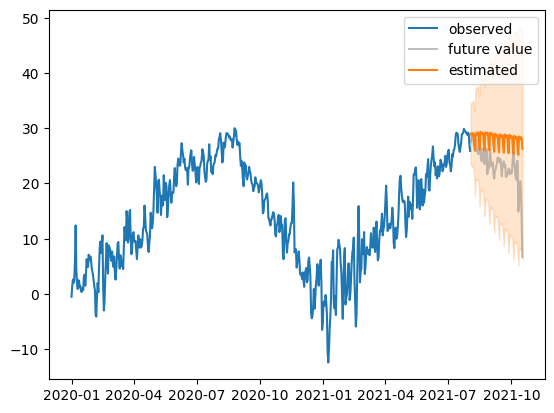

In [16]:
plt.plot(df_train.date, df_train.temp, label = 'observed')
plt.plot(df_test.date, df_test.temp, color = 'gray', alpha = 0.5, label = 'future value')
plt.plot(df_test.date, predictions['mean'], color = 'C1', label = 'estimated')
plt.fill_between(df_test.date, predictions['0.1'], predictions['0.9'], color = 'C1', alpha = 0.2)  ## 두 값 사이를 채우는 그래프
plt.legend()
plt.show()

> 이 정도 결과는(단기 추정) 나름 합리적으로 보인다.

## 4. 연구 및 토의

### **A. `static_features` vs `known_covariates`**
---




`-` `static_features`는 시점에 따라 변화하지 않는(정적인) 정보, `known_covariates`는 시점에 따라 변화하지만 이미 알고 있는 미래 시계열 정보

* 분석 타입 1 : `fit`(target의 현재까지 자료, df_train) and forecast(target의 현재까지 자료, df_train) = target의 미래
* 분석 타입 2 : `fit`(target의 현재까지의 자료 + `static_features`) and forecast(target의 현재까지의 자료 + `static_features`) = target의 미래
* 분석 타입 3 : `fit`(target의 현재까지의 자료 + 'known_covariates'의 현재까지의 자료) and forecast(target의 현재까지의 자료 + `known_covariates`의 미래 자료) = target의 미래

> 쉽게 말해서 미래의 정보는 정적인 자료(지역의 위치적 정보 등) 및 시계열 자료(지역의 예측 가능한 가변적 특성)로 예측이 가능할 것이다.

### **B. 장기 예측**
---




* 그럼 오토글루온으로 아예 장기 예측을 해버리면 어떻게 될까?

In [17]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,2:4].set_axis(['date','temp'],axis=1).assign(date= lambda df: df.date.apply(pd.to_datetime))
df_train = df[:513].assign(item_id = '평균기온')
df_test = df[513:].assign(item_id = '평균기온')

> 좀 더 미래까지 예측하고 실제와 비교하기 위해 데이터를 좀 큼지막하게 분할함

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'AutogluonModels/ag-20231219_132406'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #140-Ubuntu SMP Thu Aug 4 02:23:37 UTC 2022
CPU Count:          128
GPU Count:          0
Memory Avail:       298.85 GB / 503.74 GB (59.3%)
Disk Space Avail:   886.93 GB / 1757.88 GB (50.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 143,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'temp',
 'time_limit': 300,
 'verbosity': 2}

Provided train_data has 513 rows, 1 time series. Median time series length is 513 (min=513, max=513). 

Provided datase

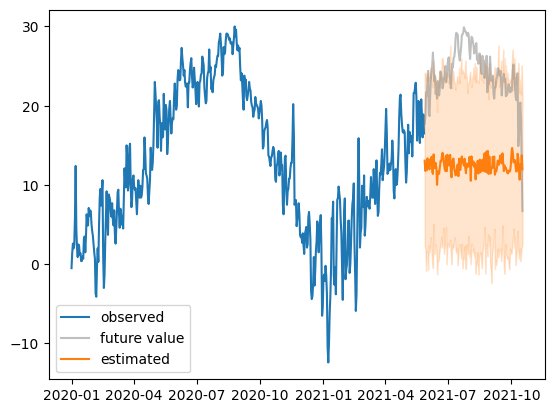

In [18]:
## step1 : TimeSeriesDF
ts_train = TimeSeriesDataFrame(
    data = df_train,
    static_features = None, 
    id_column = 'item_id',
    timestamp_column = 'date'
)

## step2 : TimeSerise Predictor
predictr = TimeSeriesPredictor(
    target = 'temp', # 예측하고 싶은것 
    known_covariates_names = None, # 온도를 예측할때 쓸 수 있는 다른 시계열 자료 
    prediction_length = len(df_test), # 예측하고 싶은 자료의 길이
    freq = 'D' # 주기 (보통은 'D', 'H'를 씀, 일반적으로 명시하지 않아도 오토글루온이 알아서 찾아줌) 
)
## step3 : fitting
predictr.fit(ts_train, time_limit = 300)
## step4 : prediction
predictr.predict(ts_train)
#---#
predictions = predictr.predict(ts_train)
plt.plot(df_train.date,df_train.temp,label='observed')
plt.plot(df_test.date,df_test.temp,color='gray',alpha=0.5,label='future value')
plt.plot(df_test.date,predictions['mean'],color='C1',label='estimated')
plt.fill_between(df_test.date, predictions['0.1'], predictions['0.9'],color='C1',alpha=0.2)
plt.legend()

> 장기 예측은 이상하게 보임... $\to$ 장기 예측은 (좁은 의미의)시계열 분석의 범위를 벗어남.

`-` 통계학과에서 배우는 시계열 분석 : **주식 시계열??**

* 주식에 대한 시계열 자료 : 시간별 독립인 듯 하지만, 사실은 독립이 아닌 자료! (오차항이 독립이 아니다!!)
    * 원래 오차항은 독립이여야 한다...(회귀분석의 가정) 주식 시계열은 비합리적인 관측자료가 됨.
    *  원래 회귀분석에서 다루는 세팅은... `관측자료 = 정보 + 오차`이다. 이를 시계열로 바꿔 표현하면...**$$주식시계열자료 = 합리적 정보 + 오차 = 합리적 정보 + 기세 + 독립오차$$**
      가 된다.
<br>

* 통계학과에서 배우는 시계열모형은 '기세'를 모델링하는 것이다. 즉, 비합리적인 오차항을 모델링하는 것이다!

    * 1시점 전의 기세에 얼마나 영향을 강하게 받는가? : AR(1) 모형의 계수값 결정
    * p시점까지의 기세에 얼마나 영향을 강하게 받는가? : AR(p) 모형의 계수값 결정... 이 경우 학습할 파라미터가 너무 많다!
      > 그런데 AR(p)와 비슷한 효과를 주고 파라미터를 더 적게 가지는 MA(q), ARMA(p, q)와 같은 모형이 존재함... 따라서 아주 먼 시점의 기세까지 분석해야 한다면(장기까지 분석해야 한다면) ARMA(p, q)를 적합하는 것이 유리함.
    * 트렌드와 계절성을 가지는 시계열 자료는 기세를 모델링하기 어려운데...?
      > 트렌드를 제거할 수 있는 ARIMA, SARIMA등이 있다.
    * 기세의 변동성이 시간에 따라 달라진다면 어쩌지...?(이분산성)
      > ARCH, GARCH등을 사용

* 합리적정보 : 시계열분석에서 합리적정보(주어진 상황에서의 평균에 대한 정보)는 `static_features`, `known_covariates`에 포함되어 있다.

`-` 장기 예측

* 장기 예측은 합리적 정보를 잘 추정하는 것이 중요하며, 이는 기세를 모델링하는 것과는 별 상관이 었다. 따라서 시계열로 장기예측을 한다? 다른 방법을 사용하는 게 더 좋음...